In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import warnings

import CM4Xutils
import numpy as np
import pandas as pd
import xarray as xr
import xgcm
import xhistogram

import gsw, xwmt
import zarr

In [8]:
import cmocean
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 12})

In [9]:
xgcm.__version__, xwmt.__version__

('0.8.2.dev15+g7492277', '0.1.1')

### Load data and create metadata structures

In [10]:
from common import *
grids = load_datasets()
grid = grids['CM4Xp125_forced']

In [11]:
wm = xwmt.WaterMass(grid)
wm.get_density("sigma2");
grid = wm.grid # reassign grid since we have modified a copy within wm
ds = grid._ds # reassign ds since we have modified a copy within grid
ds["z"] = ds.z.transpose("year", "zl", "yh", "xh")

/vftmp/Henri.Drake/pid10200/ipykernel_5967/3245835610.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(
/vftmp/Henri.Drake/pid10200/ipykernel_5967/3245835610.py:42: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(
/vftmp/Henri.Drake/pid10200/ipykernel_5967/3245835610.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(
/vftmp/Henri.Drake

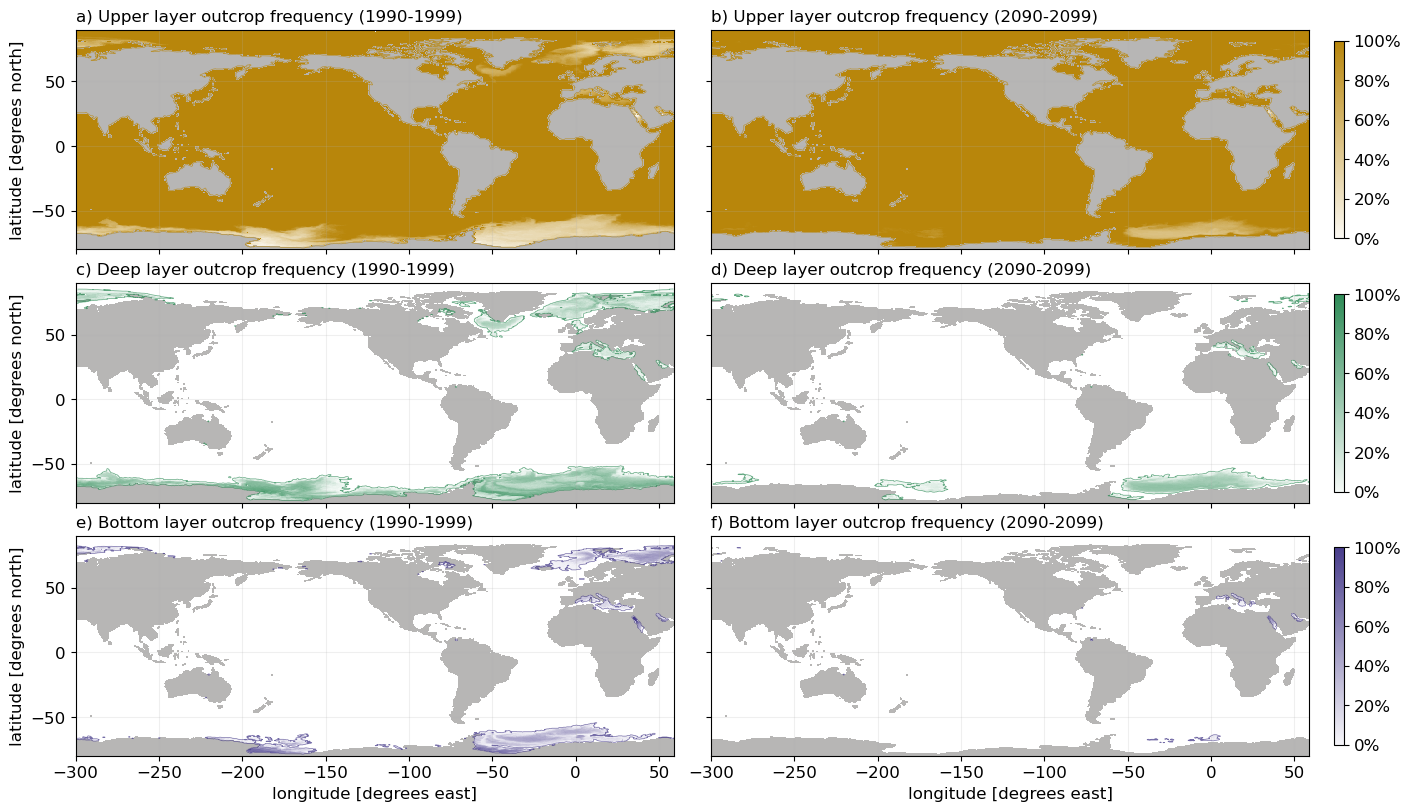

In [12]:
titles = [
    "a) Upper layer outcrop frequency (1990-1999)",
    "b) Upper layer outcrop frequency (2090-2099)",
    "c) Deep layer outcrop frequency (1990-1999)",
    "d) Deep layer outcrop frequency (2090-2099)",
    "e) Bottom layer outcrop frequency (1990-1999)",
    "f) Bottom layer outcrop frequency (2090-2099)",
]

fig, axes = plt.subplots(3,2,figsize=(14, 8), layout="constrained")

for r, years in enumerate([("1990", "1999"), ("2090", "2099")]):
    sigma = ds.sigma2_surface.sel(time=slice(*years))
    
    for k, color in enumerate(layer_colors):
        ax = axes[k,r]
        outcrop_frequency = ((sigma2_i[k] < sigma) & (sigma <= sigma2_i[k+1])).sum("time") / sigma.time.size * 100
        cm_tmp = cmap_offwhite_fade(layer_colors[k]).copy()
        cm_tmp.set_bad([0., 0., 0., 0.])
        pc = ax.pcolormesh(
            outcrop_frequency.geolon,
            outcrop_frequency.geolat,
            outcrop_frequency.where(outcrop_frequency!=0),
            cmap=cm_tmp,
            vmin=0, vmax=100
        )
        ax.contour(
            outcrop_frequency.geolon,
            outcrop_frequency.geolat,
            outcrop_frequency.fillna(0.),
            levels = [1.e-3],
            linestyles="-", linewidths=0.5, colors=layer_colors[k], alpha=0.75,
        )
        ax.set_title(titles[r+k*2], loc="left", fontsize=12)
        if k==2:
            ax.set_xlabel("longitude [degrees east]")
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])
        ax.set_ylim(-80, 90)
        ax.set_xlim(-300, 59)
        ax.pcolor(
            ds.geolon,
            ds.geolat,
            ds.deptho.fillna(0.).where(ds.deptho.fillna(0.)==0.) + 1,
            cmap=cmocean.cm.gray,
            vmin=0, vmax=1.3
        )
        ax.grid(True, alpha=0.2)

        if r==1:
            cbar = fig.colorbar(pc, ax=axes[k, :], shrink=0.9, pad=0.02)
            cbar.set_ticks([0, 20, 40, 60, 80, 100])
            cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

        if r==0: 
            axes[k][0].set_ylabel("latitude [degrees north]")
            axes[k][1].set_yticklabels([]);

plt.savefig("../figures/SFig4_layer_outcrops.png", dpi=400, bbox_inches="tight")

### Layer-wise inventory

In [13]:
dA = ds.areacello
outcrop_area = xhistogram.xarray.histogram(
    ds.sigma2_surface,
    bins=sigma2_i,
    dim=("xh", "yh",),
    weights=dA,
    bin_dim_suffix="_l",
).compute().groupby("time.year").mean("time")

In [14]:
dV = ds.areacello*ds.thkcello
volume_binned = grid.transform(
    dV,
    "Z",
    sigma2_i,
    target_data=ds.sigma2,
    method="conservative"
).rename({"sigma2": "sigma2_l"})
layer_inventory = volume_binned.sum(["xh", "yh"]).compute()

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [15]:
cfc11_content = (ds.cfc11.fillna(0.))*ds.areacello*ds.thkcello
cfc11_binned = grid.transform(
    cfc11_content,
    "Z",
    sigma2_i,
    target_data=ds.sigma2,
    method="conservative"
).rename({"sigma2": "sigma2_l"})
cfc11_layer_inventory = cfc11_binned.sum(["xh", "yh"]).compute()

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [16]:
from common import *

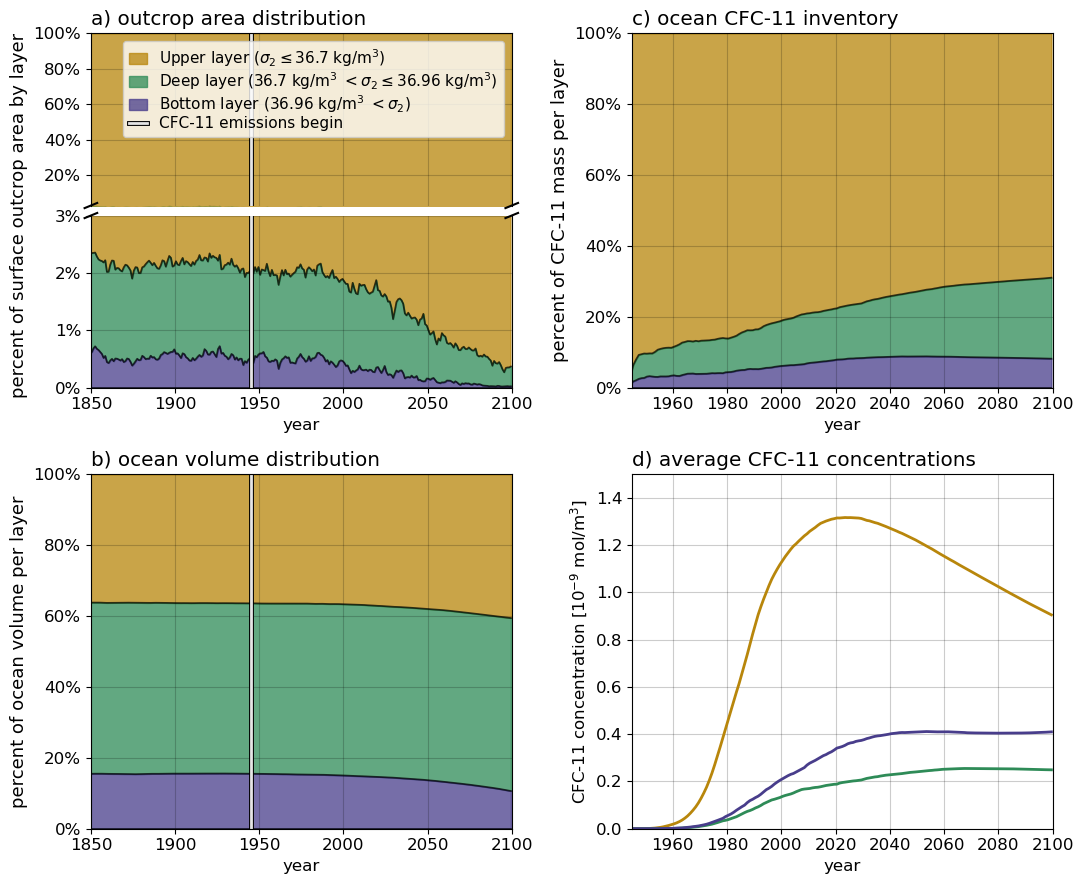

In [17]:
fig, axes = plt.subplots(2,2,figsize=(11,9))

ax = axes[0][0]
divider = make_axes_locatable(ax)
ax2 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax2)
ax.spines['top'].set_visible(False)
ax2.tick_params(bottom=False, labelbottom=False)
ax2.spines['bottom'].set_visible(False)

for k, label, color in zip([0,1,2], layer_labels, layer_colors):
    
    ax = axes.flatten()[0]
    x = pad_years(outcrop_area.year)
    y1 = pad_array(100 - outcrop_area.isel(sigma2_surface_l=slice(0,k)).sum("sigma2_surface_l") / outcrop_area.sum("sigma2_surface_l")*100)
    y2 = pad_array(100 - outcrop_area.isel(sigma2_surface_l=slice(0,k+1)).sum("sigma2_surface_l") / outcrop_area.sum("sigma2_surface_l")*100)
    ax.fill_between(x, y1, y2, label=label, color=color, alpha=0.75)
    ax.plot(x, y2, color="k", lw=1.25, alpha=0.7)
    ax2.fill_between(x, y1, y2, label=f"{label} ({sigma2_range[k]})", color=color, alpha=0.75)
    ax2.plot(x, y2, color="k", lw=1.25, alpha=0.7)
    ax2.set_ylabel("percent of surface outcrop area by layer", fontsize=13, loc="top")
    ax2.set_title("a) outcrop area distribution", loc="left")

    ax = axes.flatten()[2]
    x = pad_years(layer_inventory.year)
    y1 = pad_array(100 - layer_inventory.isel(sigma2_l=slice(0,k)).sum("sigma2_l") / layer_inventory.sum("sigma2_l")*100)
    y2 = pad_array(100 - layer_inventory.isel(sigma2_l=slice(0,k+1)).sum("sigma2_l") / layer_inventory.sum("sigma2_l")*100)    
    ax.fill_between(x, y1, y2, label=label, color=color, alpha=0.75)
    ax.plot(x, y2, color="k", lw=1.25, alpha=0.7)
    ax.set_ylabel("percent of ocean volume per layer", fontsize=13)
    ax.set_title("b) ocean volume distribution", loc="left")

    ax = axes.flatten()[1]
    x = pad_years(cfc11_layer_inventory.year)
    y1 = pad_array(100 - cfc11_layer_inventory.isel(sigma2_l=slice(0,k)).sum("sigma2_l") / cfc11_layer_inventory.sum("sigma2_l")*100)
    y2 = pad_array(100 - cfc11_layer_inventory.isel(sigma2_l=slice(0,k+1)).sum("sigma2_l") / cfc11_layer_inventory.sum("sigma2_l")*100)
    ax.fill_between(x, y1, y2, label=label, color=color, alpha=0.75)
    ax.plot(x, y2, color="k", lw=1.25, alpha=0.7)
    ax.set_ylabel("percent of CFC-11 mass per layer", fontsize=13)
    ax.set_title("c) ocean CFC-11 inventory", loc="left")
    
    ax = axes.flatten()[3]
    x = pad_years(cfc11_layer_inventory.year)
    y = pad_array((cfc11_layer_inventory/layer_inventory).isel(sigma2_l=k))
    ax.plot(x,y*1e9,color=color, lw=2)
    ax.set_ylabel(r"CFC-11 concentration [10$^{-9}$ mol/m$^{3}$]")
    ax.set_title("d) average CFC-11 concentrations", loc="left")

for ax in axes.flatten()[0:3]:
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

axes.flatten()[0].set_xlim(1850, 2100)
axes.flatten()[0].axvline(1945, color="w", alpha=0.9, lw=2, label="CFC-11 emissions begin", path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()])
ax2.axvline(1945, color="w", alpha=0.9, lw=2, label="CFC-11 emissions begin", path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()])
ax2.legend(fontsize=11, labelspacing=0.08, handlelength=1.2)
axes.flatten()[2].set_xlim(1850, 2100)
axes.flatten()[2].set_ylim(0, 100)
axes.flatten()[2].axvline(1945, color="w", alpha=0.9, lw=2, label="CFC-11 emissions begin", path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()])
axes.flatten()[1].set_xlim(1945, 2100)
axes.flatten()[3].set_xlim(1945, 2100)
axes.flatten()[3].set_ylim(0, 1.5)

ax = axes[0][0]
# From https://matplotlib.org/examples/pylab_examples/broken_axis.html
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax.set_ylim(0, 3)
ax.set_xlim(1850, 2100)
ax2.set_ylim(3, 100)
ax2.set_xlim(1850, 2100)

for ax in axes.flatten():
    ax.grid(True, alpha=0.2, color="k")
    ax.set_xlabel("year")
ax2.grid(True, alpha=0.2, color="k")

plt.tight_layout()
plt.savefig("../figures/Fig3_layered_cfc11_inventory.png", bbox_inches="tight", dpi=300)